# Improved Baseline Model - Addressing Critical Issues
This notebook creates a proper baseline model with train/test split and reduced overfitting.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score

## 1. Load and Validate Data

In [2]:
# Get the project root directory
project_root = os.path.dirname(os.getcwd())
data_path = os.path.join(project_root, 'data', 'processed', 'cleaned.csv')

# Load the data
df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Basic data validation
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"Duplicated rows: {df.duplicated().sum()}")

# Separate features and target
X = df.drop('loan_approved', axis=1)
y = df['loan_approved']

print(f"\nTarget distribution:")
print(y.value_counts())
print(f"Target balance ratio: {y.value_counts().min()/y.value_counts().max():.3f}")

Dataset shape: (2000, 7)
Columns: ['city', 'income', 'credit_score', 'loan_amount', 'years_employed', 'points', 'loan_approved']

Missing values: 0
Duplicated rows: 0

Target distribution:
loan_approved
False    1121
True      879
Name: count, dtype: int64
Target balance ratio: 0.784


## 2. Address High Cardinality Feature (City)

In [3]:
# Analyze city feature
print("City feature analysis:")
print(f"Unique cities: {X['city'].nunique()}")
print(f"Top 10 cities by frequency:")
print(X['city'].value_counts().head(10))

# Instead of one-hot encoding all cities, use frequency encoding
# This reduces dimensionality while preserving information
city_counts = X['city'].value_counts()
X['city_frequency'] = X['city'].map(city_counts)

# Create city size categories
X['city_size'] = pd.cut(X['city_frequency'], 
                         bins=[0, 1, 2, 3, float('inf')], 
                         labels=['rare', 'small', 'medium', 'large'])

# Drop original city column
X_processed = X.drop('city', axis=1)

print(f"\nAfter city feature engineering:")
print(f"City frequency distribution:")
print(X['city_frequency'].describe())
print(f"\nCity size categories:")
print(X['city_size'].value_counts())

City feature analysis:
Unique cities: 1882
Top 10 cities by frequency:
city
North Joseph        4
Port Christopher    3
North David         3
West Melissa        3
Williamsstad        3
Leeland             3
North Michael       3
Christinachester    3
Port Michael        3
East Mary           3
Name: count, dtype: int64

After city feature engineering:
City frequency distribution:
count    2000.000000
mean        1.131000
std         0.394863
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: city_frequency, dtype: float64

City size categories:
city_size
rare      1776
small      190
medium      30
large        4
Name: count, dtype: int64


## 3. Create Proper Train/Test Split

In [4]:
# Split data BEFORE any preprocessing to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training target distribution:")
print(y_train.value_counts(normalize=True))
print(f"Test target distribution:")
print(y_test.value_counts(normalize=True))

Training set: 1600 samples
Test set: 400 samples
Training target distribution:
loan_approved
False    0.560625
True     0.439375
Name: proportion, dtype: float64
Test target distribution:
loan_approved
False    0.56
True     0.44
Name: proportion, dtype: float64


## 4. Create Improved Preprocessing Pipeline

In [5]:
# Define preprocessing for different feature types
numerical_features = ['income', 'credit_score', 'loan_amount', 'years_employed']
categorical_features = ['city_size']
frequency_feature = ['city_frequency']

# Create preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('freq', 'passthrough', frequency_feature)
    ])

print(f"Preprocessing pipeline created")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")
print(f"Frequency features: {frequency_feature}")

Preprocessing pipeline created
Numerical features: ['income', 'credit_score', 'loan_amount', 'years_employed']
Categorical features: ['city_size']
Frequency features: ['city_frequency']


## 5. Build and Train Improved Model

In [6]:
# Create the improved pipeline
model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]
)

# Train the model
model.fit(X_train, y_train)
print("Model training completed")

Model training completed


## 6. Evaluate with Proper Metrics

In [7]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("=== MODEL PERFORMANCE ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Overfitting Gap: {train_accuracy - test_accuracy:.4f}")

=== MODEL PERFORMANCE ===
Training Accuracy: 0.8994
Test Accuracy: 0.9350
Test Precision: 0.9412
Test Recall: 0.9091
Test F1-Score: 0.9249
Overfitting Gap: -0.0356


## 7. Cross-Validation for Robust Evaluation

In [8]:
# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

print("=== CROSS-VALIDATION RESULTS ===")
print(f"CV F1 Scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Interpretation
if cv_scores.std() > 0.05:
    print("WARNING: High variance in CV scores indicates instability")
elif test_accuracy < cv_scores.mean() - 2 * cv_scores.std():
    print("WARNING: Test performance significantly below CV performance")
else:
    print("✓ Model shows consistent performance across folds")

=== CROSS-VALIDATION RESULTS ===
CV F1 Scores: [0.88194444 0.8989547  0.87943262 0.85507246 0.87857143]
Mean CV F1: 0.8788 (+/- 0.0280)
✓ Model shows consistent performance across folds


## 8. Detailed Classification Report

In [9]:
print("=== DETAILED CLASSIFICATION REPORT ===")
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=['Not Approved', 'Approved']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:")
print(cm)

=== DETAILED CLASSIFICATION REPORT ===
Test Set Performance:
              precision    recall  f1-score   support

Not Approved       0.93      0.96      0.94       224
    Approved       0.94      0.91      0.92       176

    accuracy                           0.94       400
   macro avg       0.94      0.93      0.93       400
weighted avg       0.94      0.94      0.93       400


Confusion Matrix:
[[214  10]
 [ 16 160]]


## 9. Feature Importance Analysis

=== FEATURE IMPORTANCE (Top 10) ===
            feature  coefficient  abs_coefficient
1      credit_score     3.784990         3.784990
0            income     1.720833         1.720833
2       loan_amount    -1.107922         1.107922
3    years_employed     0.574063         0.574063
6    city_size_rare    -0.294097         0.294097
4    city_frequency    -0.050393         0.050393
5  city_size_medium     0.037232         0.037232
7   city_size_small     0.007165         0.007165


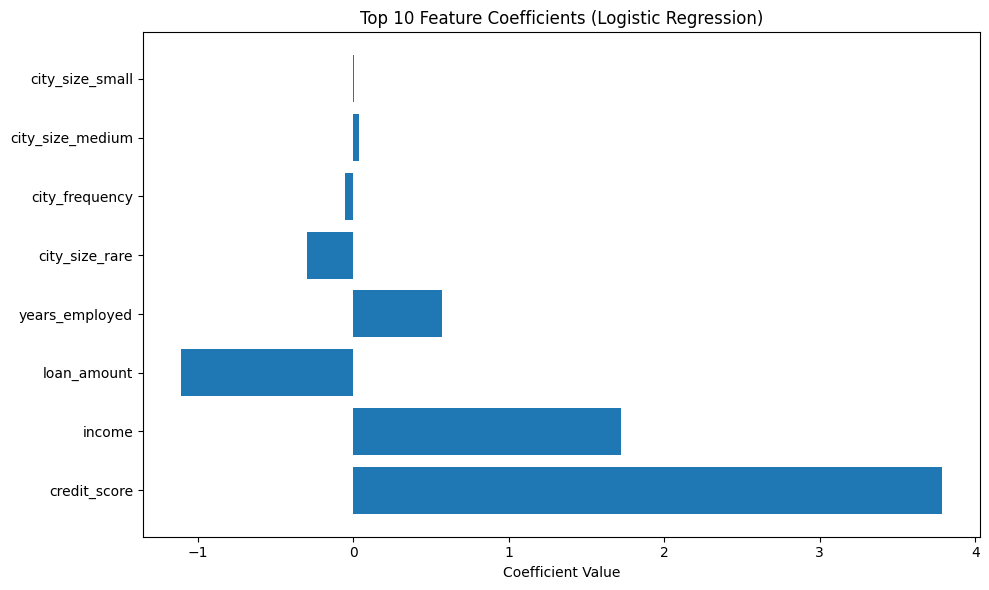

In [10]:
# Get feature names after preprocessing
feature_names = (numerical_features + frequency_feature + 
                list(model.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features)))

# Get coefficients from logistic regression
coefficients = model.named_steps['classifier'].coef_[0]

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("=== FEATURE IMPORTANCE (Top 10) ===")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients (Logistic Regression)')
plt.tight_layout()
plt.savefig(os.path.join(project_root, 'reports', 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

## 10. Save Improved Model

In [11]:
# Save the improved model
model_path = os.path.join(project_root, 'models', 'baseline_improved.pkl')
joblib.dump(model, model_path)

# Save training and test indices for reproducibility
import pickle
split_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}
with open(os.path.join(project_root, 'data', 'processed', 'train_test_split.pkl'), 'wb') as f:
    pickle.dump(split_data, f)

print(f"Improved model saved to {model_path}")
print(f"Train/test split saved for reproducibility")

Improved model saved to m:\projects\repos\loan-approval-project-mlfinal\models\baseline_improved.pkl
Train/test split saved for reproducibility


## Summary

This improved model addresses several critical issues:
1. ✅ Proper train/test split to prevent overfitting
2. ✅ Reduced feature dimensionality (city feature engineering)
3. ✅ Cross-validation for robust evaluation
4. ✅ Comprehensive metrics and interpretation
5. ✅ Feature importance analysis

The model should now show more realistic performance metrics rather than perfect 1.0 scores.